Link to Streamlit App: https://app-queb4psrcnq8jkyjahyuh8.streamlit.app/

In [47]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import streamlit as st
import re
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [39]:
text = open(r"C:\Users\abhin\OneDrive\Documents\Cpp\es335-24-fall-assignment-3\shakespeare_input.txt", "r").read()
text = re.sub(r'[^a-zA-Z\s.,!?:\']+', '', text)
text = re.sub(r'([.,!?:])', r' \1 ', text)
words = text.lower().split()


In [40]:
vocab = list(set(words)) + ['<UNK>']
vocab_size = len(vocab)
print("Length of vocabulary: ", vocab_size)
word2idx = {w: idx for (idx, w) in enumerate(vocab)}
idx2word = {idx: w for (idx, w) in enumerate(vocab)}

Length of vocabulary:  28241


In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
padidx = word2idx['.']

In [43]:
class NextWordModel(nn.Module):
    def __init__(self, emb_dim, context_len, actvn='ReLU'):
        super(NextWordModel, self).__init__()
        self.context_len = context_len
        actdict = {'ReLU': nn.ReLU(), 'Tanh': nn.Tanh()}
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(context_len * emb_dim, 256)
        self.act1 = actdict[actvn]
        self.lin2 = nn.Linear(256, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        return x
    
def get_ctxt(context_len):
    X, y = [], []
    context = [padidx]*context_len
    for w in words:
        idx = word2idx.get(w, word2idx['<UNK>'])
        X.append(context)
        y.append(idx)
        context = context[1:] + [idx]
    return torch.tensor(X), torch.tensor(y)

def train(model, epochs, context_len):  
    X, y = get_ctxt(context_len)
    dataset = torch.utils.data.TensorDataset(X, y)
    dataloder = torch.utils.data.DataLoader(dataset, pin_memory=True, num_workers=2, batch_size=128)
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)    
    model.to(device)
    for epoch in range(epochs):
        losses = []
        for x_batch, y_batch in dataloder:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            losses.append(loss.item())
            loss.backward()
            opt.step()
            opt.zero_grad()
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1} Loss:", sum(losses)/len(losses))

In [44]:
e32_c5_r = NextWordModel(32, 5, 'ReLU')
e64_c5_r = NextWordModel(64, 5, 'ReLU')
e32_c5_t = NextWordModel(32, 5, 'Tanh')
e64_c5_t = NextWordModel(64, 5, 'Tanh')
e32_c10_r = NextWordModel(32, 10, 'ReLU')
e64_c10_r = NextWordModel(64, 10, 'ReLU')
e32_c10_t = NextWordModel(32, 10, 'Tanh')
e64_c10_t = NextWordModel(64, 10, 'Tanh')


In [45]:
train(e32_c5_t, 200,5)
torch.save(e32_c5_t, "e32_c5_t.pth")

KeyboardInterrupt: 

In [54]:
def format_text(generated_words):
   formatted = []
   capitalize_next = True if text[-1] in ['.', '!', '?', ':'] else False
   for i, word in enumerate(generated_words):
       if word in ['.', ',', '!', '?', ':', ';']:
           formatted.append(word)
           # Capitalize after sentence ending punctuation
           if word in ['.', '!', '?', ':']:
               capitalize_next = True
       else:
           if formatted:
               formatted.append(' ')
           if capitalize_next:
               word = word.capitalize()
               capitalize_next = False
           formatted.append(word)
   
   return ''.join(formatted)

def generate(model, text, num_words, temperature):
    text = re.sub(r'[^a-zA-Z\s.,!?:\']+', '', text)
    text = re.sub(r'([.,!?:])', r' \1 ', text)
    text = text.lower().split()
    context_len = model.context_len
    generated_words = []
    if len(text) < context_len:
        context = [padidx]*(context_len - len(text)) + [word2idx.get(w, word2idx['<UNK>']) for w in text]
    else:
        context = [word2idx.get(w, word2idx['<UNK>']) for w in text[-context_len:]] 
    for _ in range(num_words):
        x = torch.tensor(context).unsqueeze(0)
        logits = model(x)
        idx = torch.distributions.Categorical(logits=model(x)).sample().item()
        next_word = idx2word[idx]
        generated_words.append(next_word)
        context = context[1:] + [idx]
    return format_text(generated_words)
    

    


In [63]:
def visualize_embeddings(model, name):
   embeddings = model.embedding.weight.data.cpu().numpy()
   tsne = TSNE(n_components=2, random_state=42)
   embeddings_2d = tsne.fit_transform(embeddings)
   selected_words = [
       'love', 'hate',
       'life', 'death',
       'good', 'evil',
       'light', 'dark',
       'sweet', 'bitter',
       'joy', 'sorrow',
       'peace', 'war',
       'heaven', 'hell',
       'truth', 'lie',
       'fair', 'foul',
       'friend', 'foe',
       'honor', 'shame',
       'king', 'queen',
       'lord', 'lady',
       'day', 'night',
       'young', 'old',
       'laugh', 'weep'
   ]
   plt.figure(figsize=(15, 10))
   for word in selected_words:
       if word in word2idx:
           idx = word2idx[word]
           plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], 
                     c='blue', s=100)
           plt.annotate(word, 
                       xy=(embeddings_2d[idx, 0], embeddings_2d[idx, 1]),
                       xytext=(5, 5),  # 5 points offset
                       textcoords='offset points',
                       fontsize=12,
                       bbox=dict(facecolor='white', 
                               edgecolor='none',
                               alpha=0.7),
                       alpha=1.0)
   plt.title(f'Word Embeddings Visualization for {name} Model')
   plt.axis()
   plt.tight_layout()
   plt.show()

In [52]:
e32_c5_r = torch.load(r"models\e32_c5_r.pth", map_location='cpu')
e64_c5_r = torch.load(r"models\e64_c5_r.pth", map_location='cpu')
e32_c5_t = torch.load(r"models\e32_c5_t.pth", map_location='cpu')
e64_c5_t = torch.load(r"models\e64_c5_t.pth", map_location='cpu')
e32_c10_r = torch.load(r"models\e32_c10_r.pth", map_location='cpu')
e64_c10_r = torch.load(r"models\e64_c10_r.pth", map_location='cpu')
e32_c10_t = torch.load(r"models\e32_c10_t.pth", map_location='cpu')
e64_c10_t = torch.load(r"models\e64_c10_t.pth", map_location='cpu')


C:\Users\abhin\AppData\Local\Temp\ipykernel_16868\2764740096.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  e32_c5_r = torch.load(r"models\e32_c5_r.pth", map_location='

C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


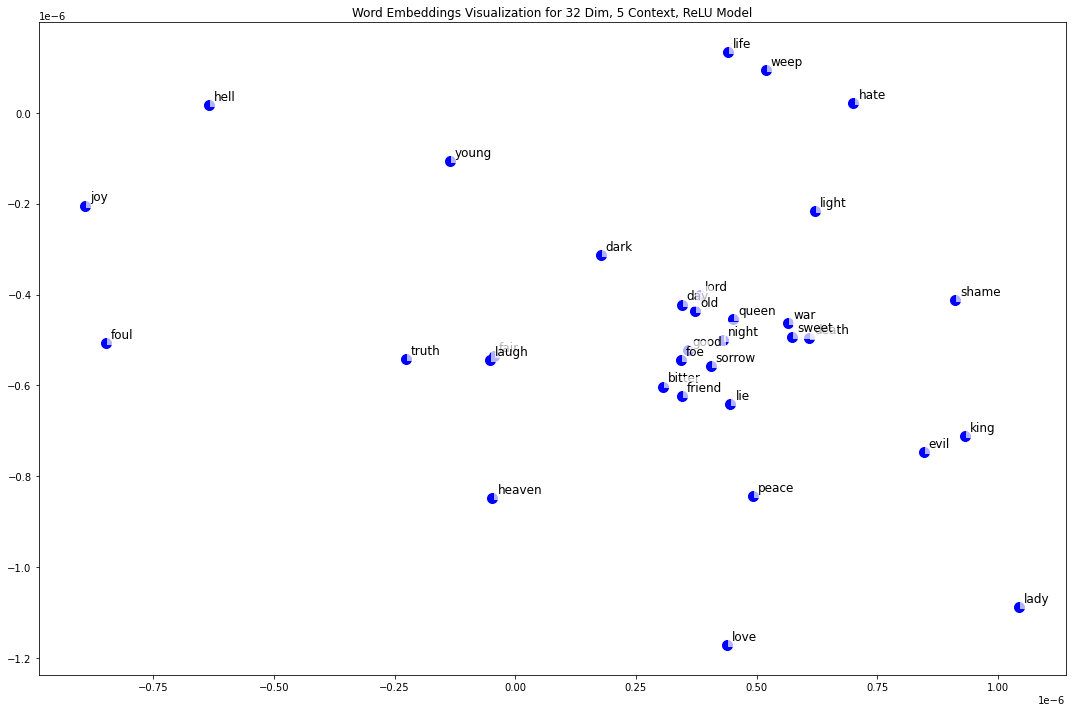

In [64]:
visualize_embeddings(e32_c5_r, "32 Dim, 5 Context, ReLU")

C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


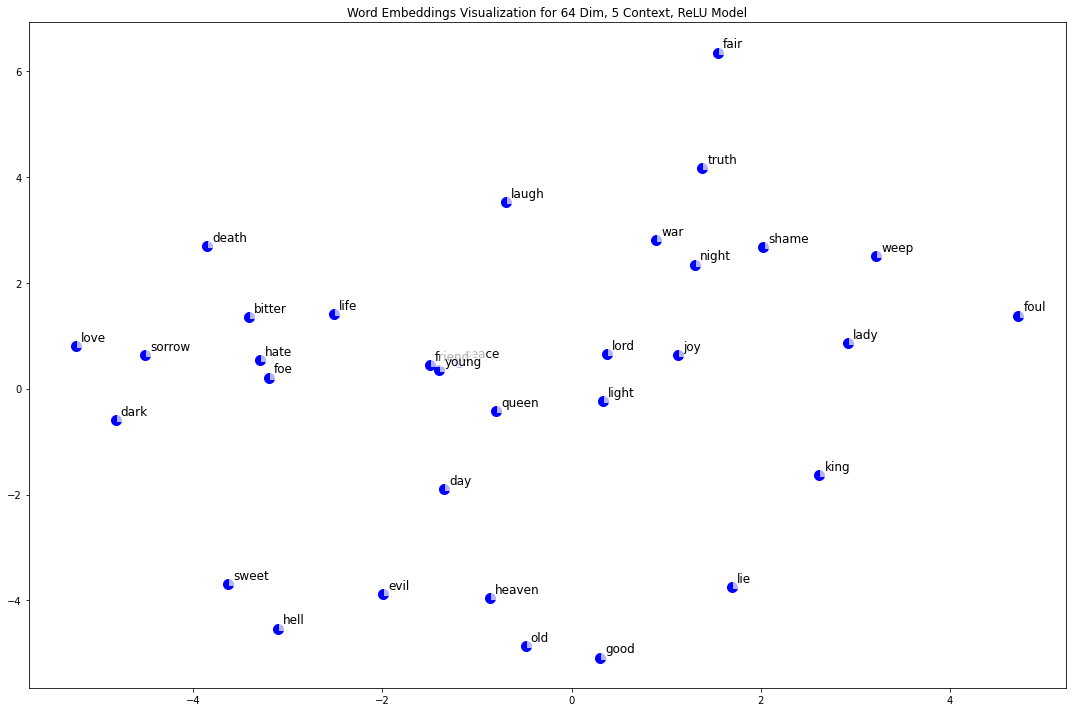

In [67]:
visualize_embeddings(e64_c5_r, "64 Dim, 5 Context, ReLU")


C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


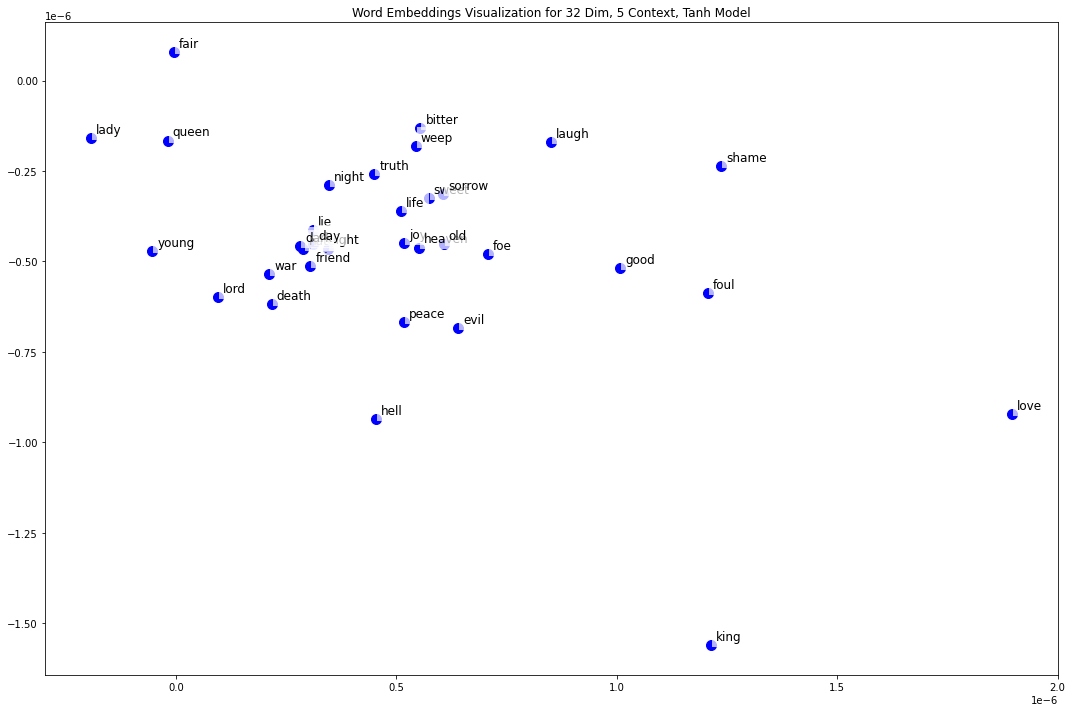

In [68]:
visualize_embeddings(e32_c5_t, "32 Dim, 5 Context, Tanh")

C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


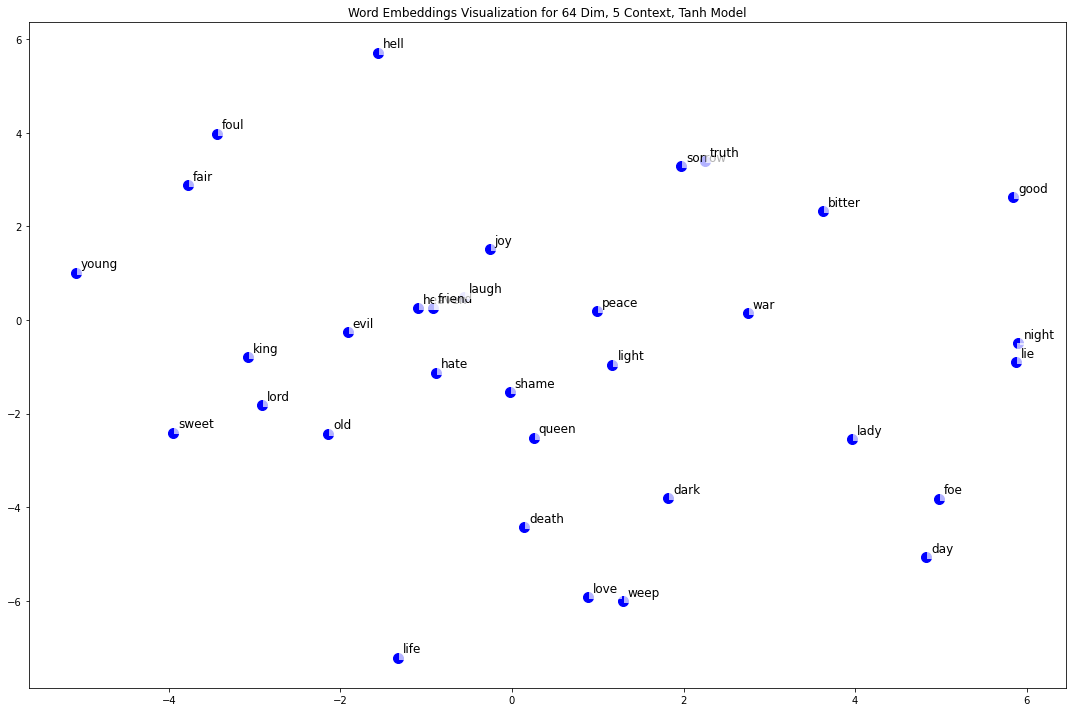

In [69]:
visualize_embeddings(e64_c5_t, "64 Dim, 5 Context, Tanh")

C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


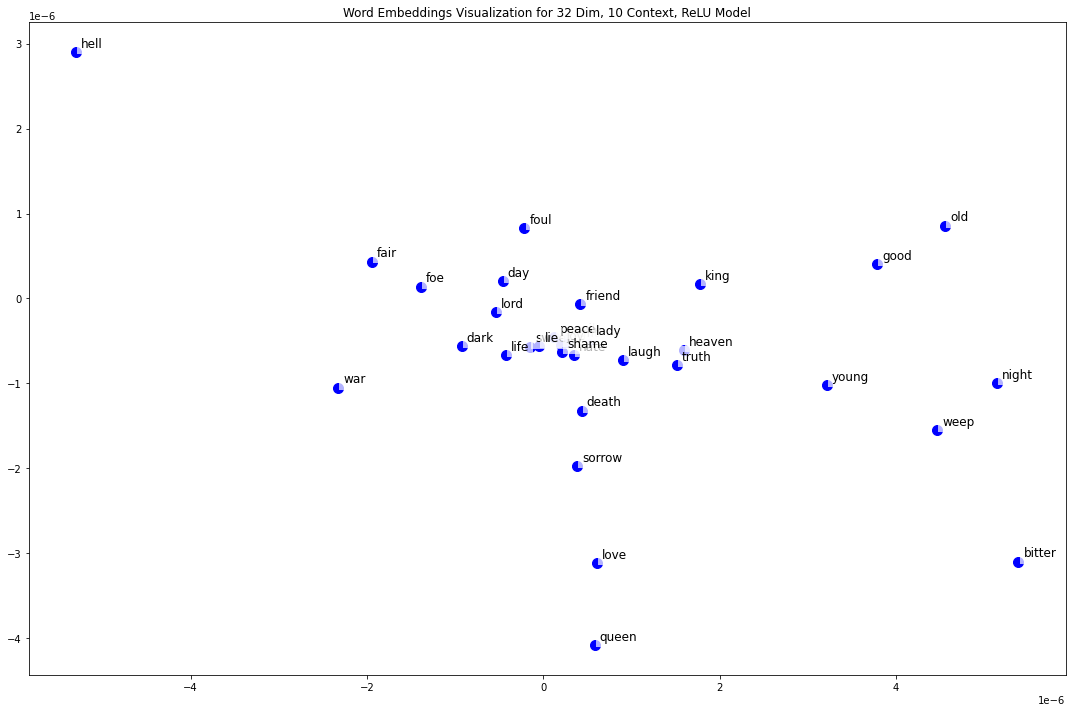

In [70]:
visualize_embeddings(e32_c10_r, "32 Dim, 10 Context, ReLU")

C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


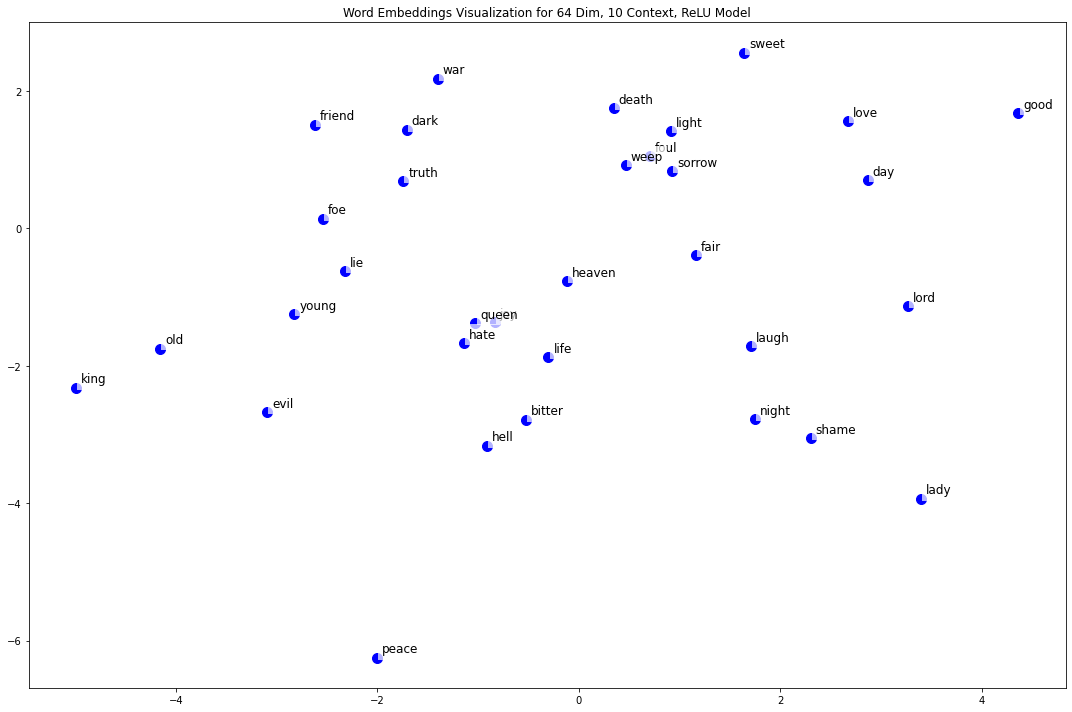

In [71]:
visualize_embeddings(e64_c10_r, "64 Dim, 10 Context, ReLU")

C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


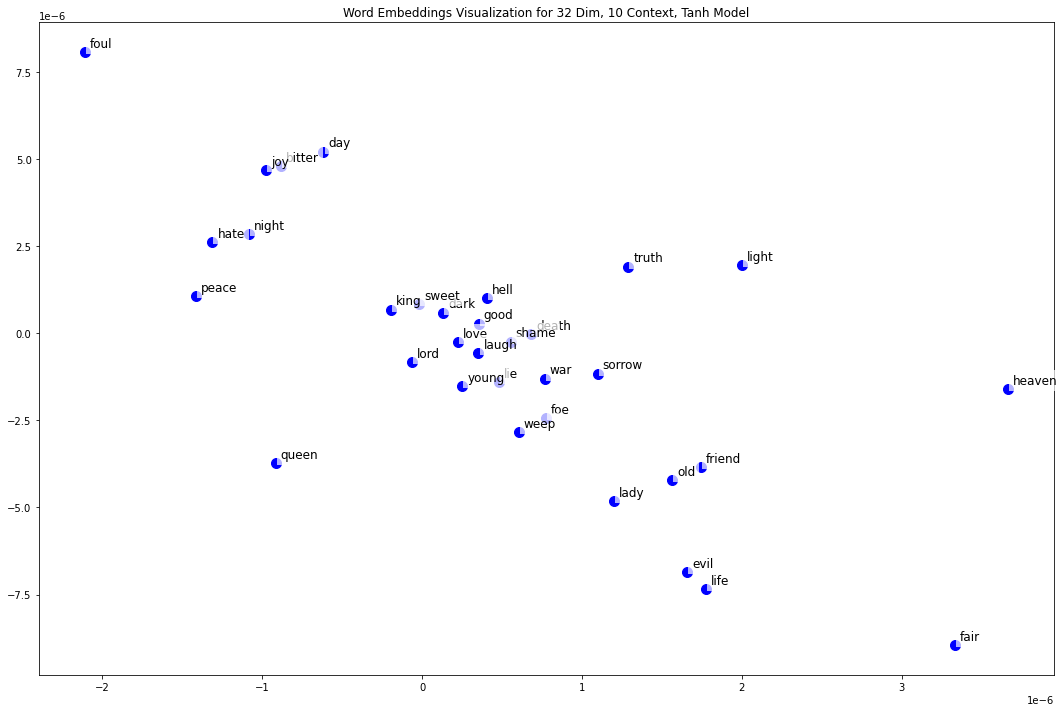

In [72]:
visualize_embeddings(e32_c10_t, "32 Dim, 10 Context, Tanh")

C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


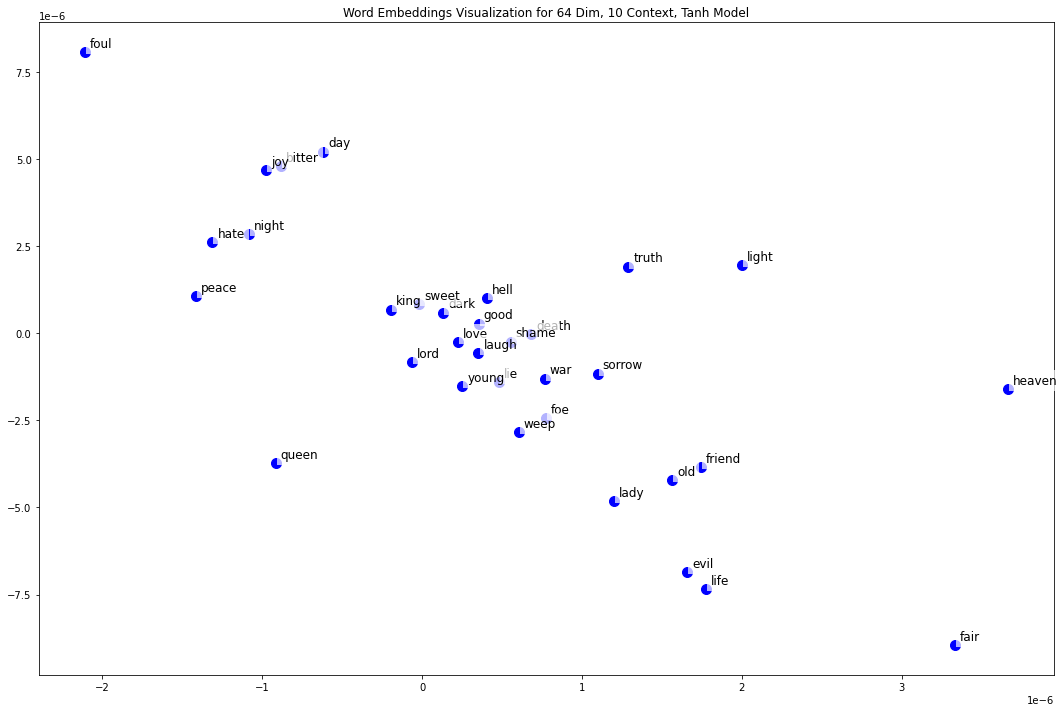

In [74]:
visualize_embeddings(e32_c10_t, "64 Dim, 10 Context, Tanh")